In [1]:
import os
import pandas as pd 
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

from neuron_morphology.swc_io import morphology_from_swc
from morph_utils.visuals import basic_morph_plot
from morph_utils.measurements import leftextent, rightextent #cellwidth, downextent, upextent
from morph_utils.templates import load_layer_template 

import sys 
sys.path.append(r'..\utils') 
from utils import add_swc_paths, get_seaad_colors, get_tx_order


In [2]:
analysis_save_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250603_seaad'

In [3]:
class_col = 'class_label_assignment_winner'
subclass_col = 'subclass_label_assignment_winner'
cluster_col = 'cluster_label_assignment_winner'

In [4]:
# organize by HANN(SEAAD)

viewer_type = 'dendrite' #dendrite, axon, both 
species = "human"

cells_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\{}\metadata.csv'.format(viewer_type)
viewer_dir = os.path.join(analysis_save_root, 'viewers') 
viewer_outfile = os.path.join(viewer_dir, 'human_excitatory_page_viewer_{}_byTtypeHANN_bySomaDepth.pdf'.format(viewer_type))
os.makedirs(viewer_dir, exist_ok=True)

# node types to plot i.e. [soma, axon, basal, apical] 
if viewer_type == 'both': compartment_list=[1,2,3,4]
elif viewer_type == 'axon': compartment_list=[1,2]
elif viewer_type == 'dendrite': compartment_list=[1,3,4] 

ttype_var_name = cluster_col
subclass_var_name = subclass_col
sort_by = [ttype_var_name, 'soma_distance_from_pia'] 
plot_view = 'xy' #'xy', 'yz', or 'both'
num_rows = 4

metadata = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250701\Datalock_Human_Glut_4_4_25(patchseq_mapping_results).csv', encoding='latin1') #has soma depths for many cells (not just reconstructed) 

#optional 
layer_aligned_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\SWC_LayerAligned' #path to folder with layer aligned swcs for these cells 
soma_depths_path = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\{}\AlignedSomaDepths.csv'.format(viewer_type) #if need to add soma depths to the file 
title = ['specimen_id', 'structure'] #, 'SEAAD_cluster_Corr', 'SEAAD_cluster_label.bootstrapping_probability', 'SEAAD_cluster_label.avg_correlation'] #variables to put in cell title - must be column names in input cells csv
title_font_size = [2,3] #,3,3,3] #font size for parts of title


Organize

In [ ]:
# Load data
cells = pd.read_csv(cells_path, index_col='specimen_id')
if 'soma_depths_path' in locals(): #add soma depths 
    soma_depths = pd.read_csv(soma_depths_path)
    cells = cells.merge(soma_depths, how='inner', on='specimen_id')
cells = cells.rename(columns={'soma_distance_from_pia_x':'soma_distance_from_pia'})

# Get layer and color data
layer_info, layer_labels, layer_colors = load_layer_template(species)
color_dict = get_seaad_colors()

#map the normalized depth in pia to the average layer pia/wm values 
avg_pia = layer_info['1']
avg_wm = layer_info['wm']
metadata['depth_from_pia_norm_to_layers'] = metadata['depth_from_pia_norm'].apply(lambda x: x * (avg_wm - avg_pia) + avg_pia if pd.notnull(x) else np.nan)

# Set some vars
cluster_var = sort_by[0]

if plot_view == 'yz': set_side = [True]
elif plot_view == 'both': set_side = [False, True]
else: set_side = [False] #xy or other

# Get layer aligned files
cells = add_swc_paths(cells, layer_aligned_dir, column_name='SWC_layer_aligned')

# Get subclass/ttype order for sorting
ttype_order, subclass_order = get_tx_order() #cells, ttype_var_name)
cells[ttype_var_name] = pd.Categorical(cells[ttype_var_name], categories=ttype_order, ordered=True)
cells[subclass_var_name] = pd.Categorical(cells[subclass_var_name], categories=subclass_order, ordered=True)

# Sort cells 
if all(item in list(cells.columns) for item in sort_by): #check if all items in sort_by are column names in cells 
    sorted_cells = cells.sort_values(by=sort_by)
else:
    print('Warning: cannot sort cells. Some value(s) in \'sort_by\' are not column names in input cell csv. Plotting unsorted cells.')
    sorted_cells = cells


Plot

Sps list is 314 long


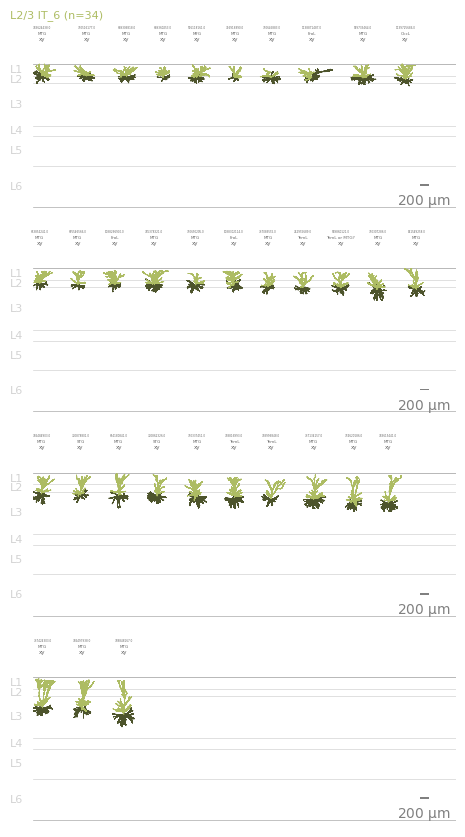

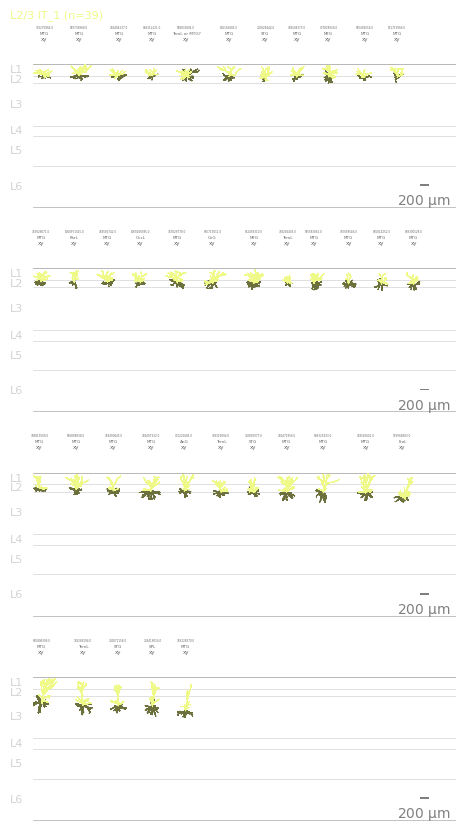

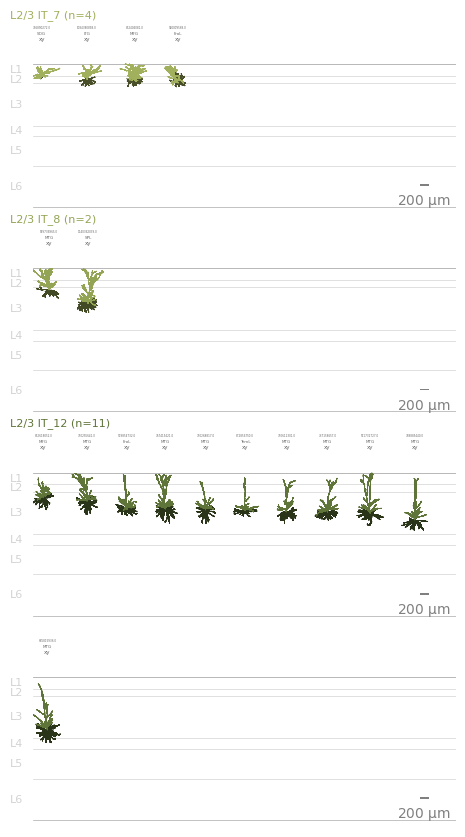

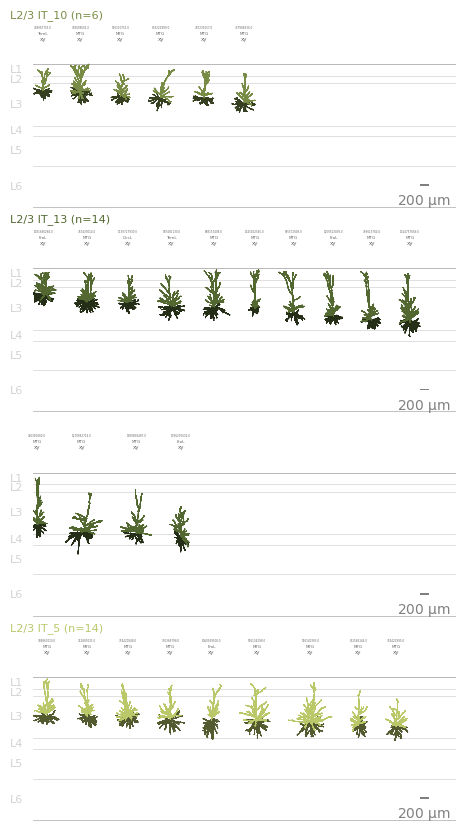

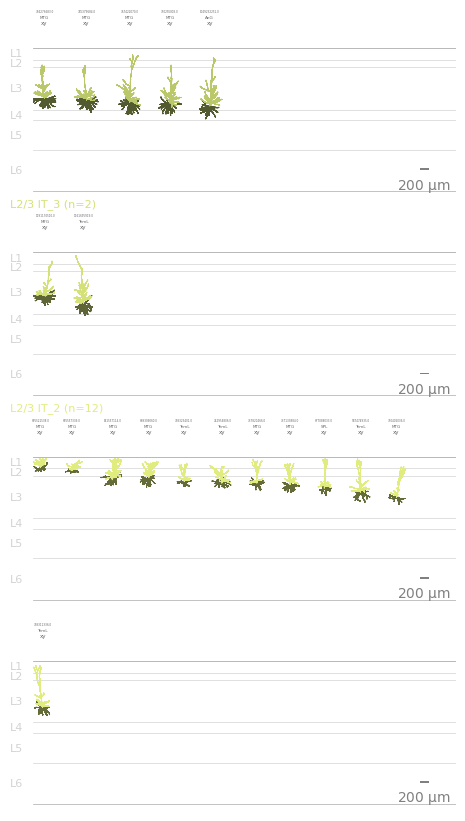

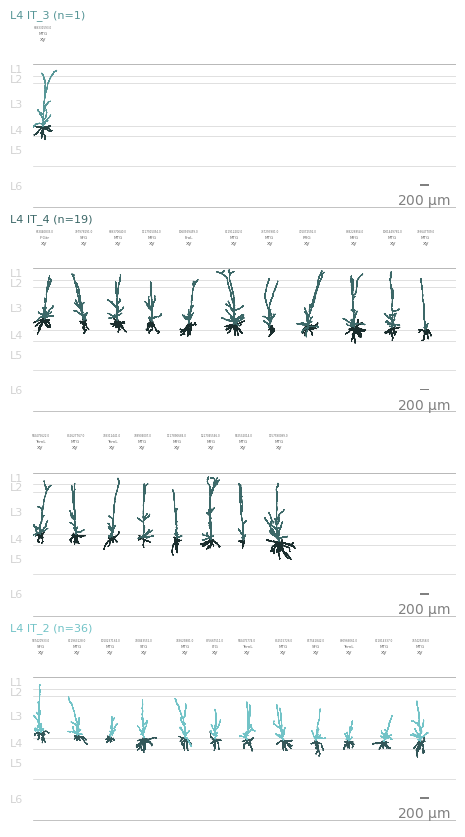

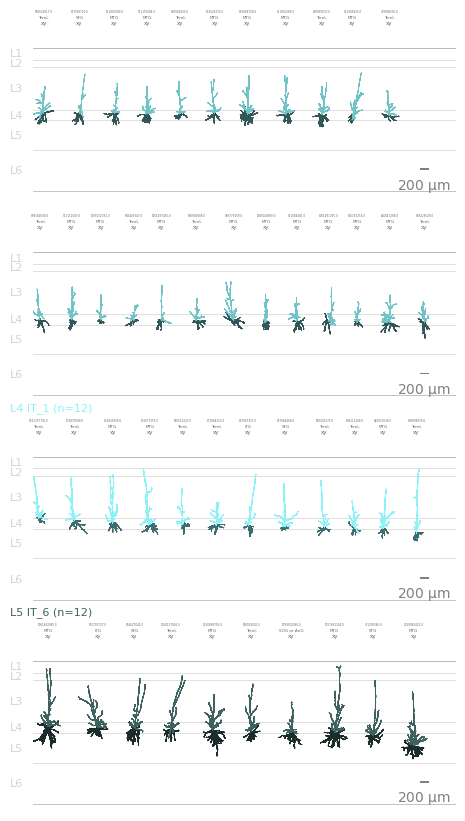

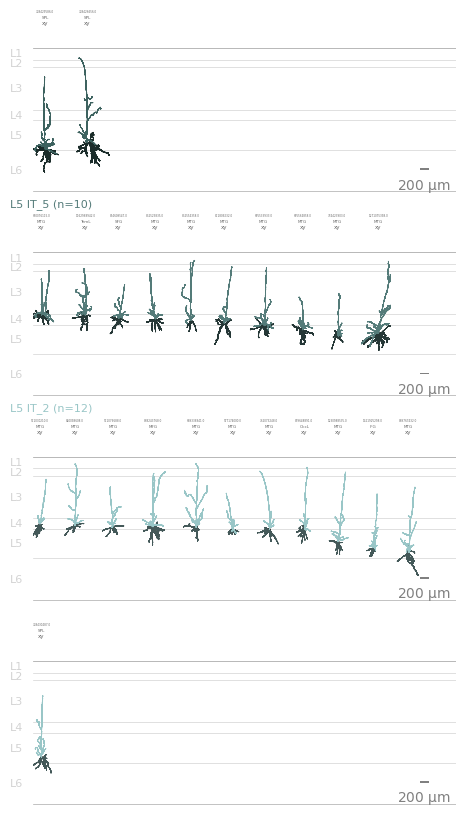

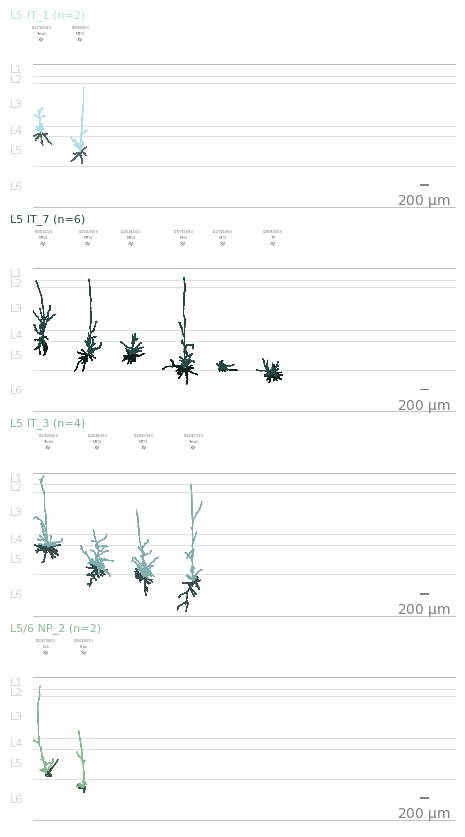

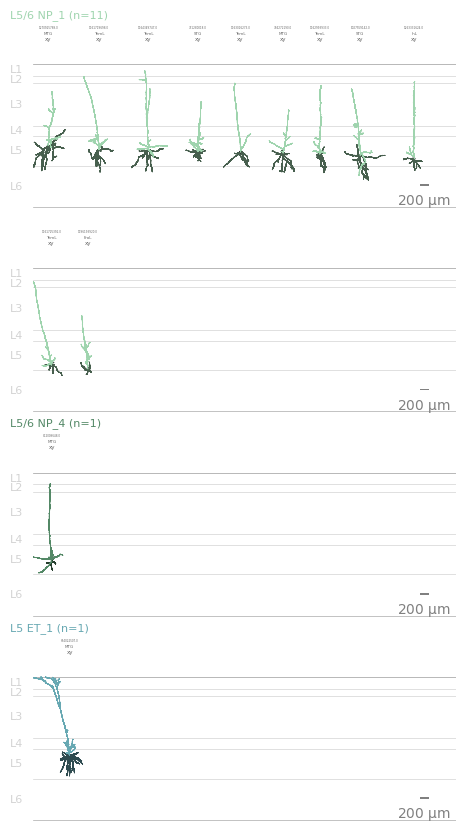

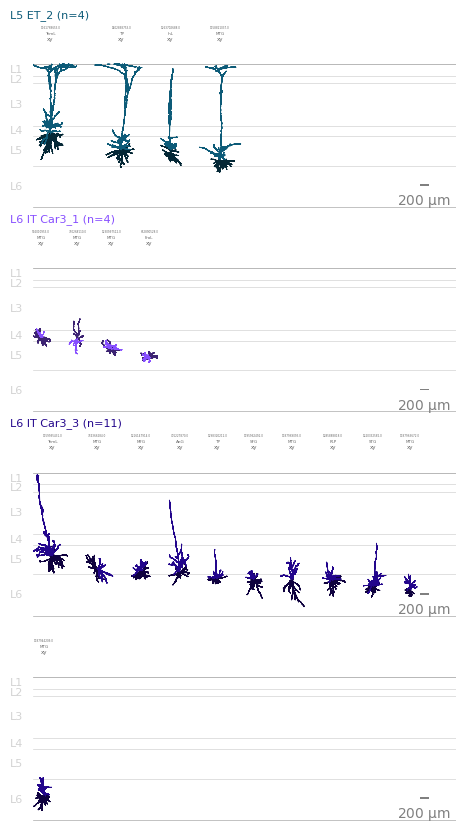

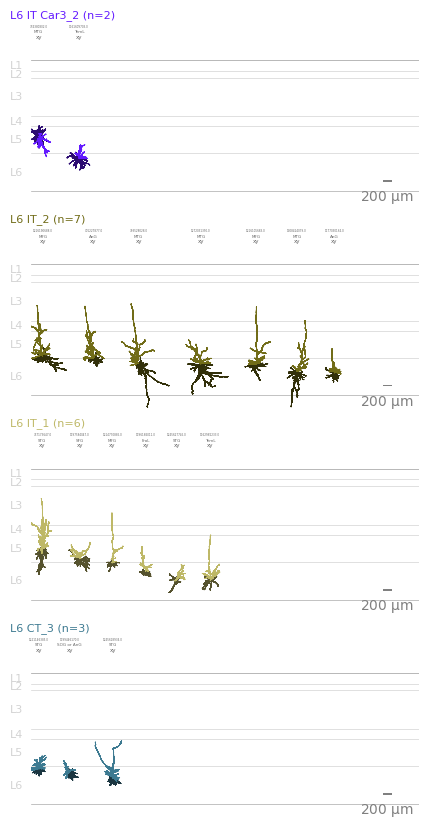

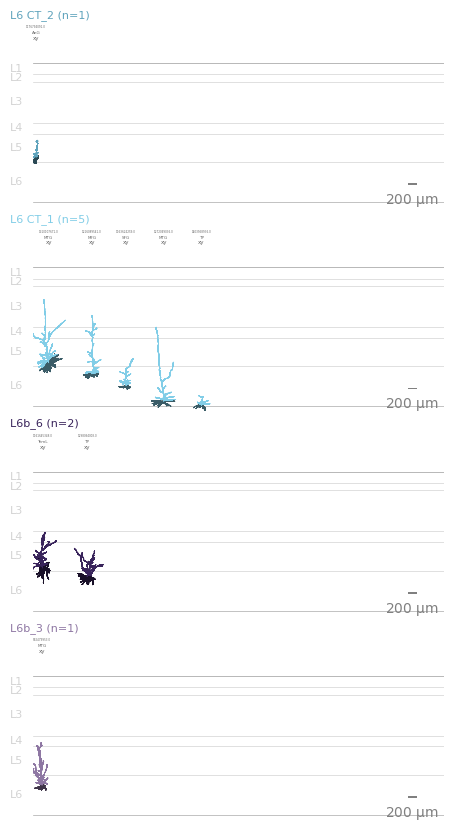

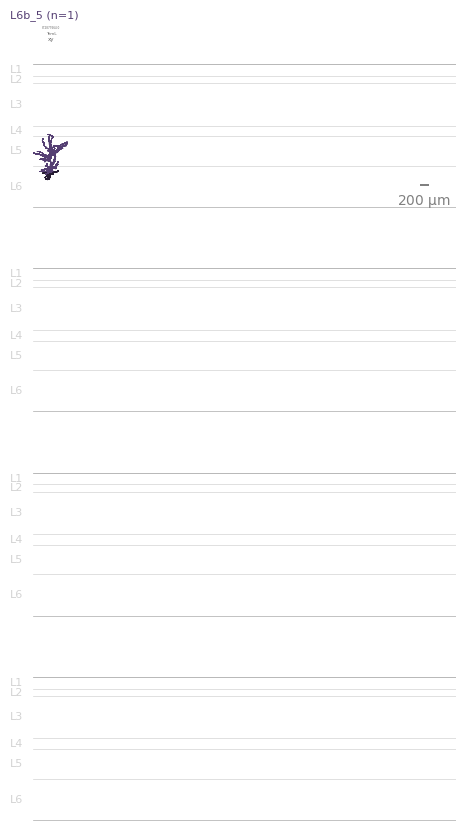

<Figure size 640x480 with 0 Axes>

In [ ]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 1000 #900 #starting height for group (e.g., region) title 
group_title_font_size = 8 #font size for group (e.g., region) title 

cell_title_start_height = 900 #700 #starting height for cell title 
cell_title_vertical_space = 130 #150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    sps_list = list(sorted_cells.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=400
    with PdfPages(viewer_outfile) as pdf:
        while sps_list != []:
            fig, axes = plt.subplots(nrows=num_rows,ncols=1,figsize=(7.5,10),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) 
            for ax in axes: 

                ax.axis('off')
                ax.set_xlim(0,9100) 
                lim = 9000
                xloc = 0
                xoffset = 0
                ax.set_anchor('W')
                ax.axhline(0, c="lightgrey",linewidth=0.50)

                # Plot layers with labels 
                for l in layer_info:
                    ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
                for l in layer_labels:
                    ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=group_title_font_size, color='lightgrey') 
                
                while xloc < lim: #plot as many neurons as fit on this row
                    if sps_list != []:
                        sp = sps_list.pop() 
                        
                        # get data for this specimen
                        ttype = sorted_cells[sorted_cells.specimen_id==sp][ttype_var_name].iloc[0]
                        clust_id = sorted_cells[sorted_cells.specimen_id==sp][cluster_var].iloc[0]
                        clust_len = len(sorted_cells[sorted_cells[cluster_var]==clust_id])

                        # cell title
                        sp_title = []
                        if 'title' in locals():
                            for t in title:
                                sp_title.append(str(sorted_cells[sorted_cells.specimen_id==sp][t].iloc[0]))
                        
                        # get plotting colors 
                        try:
                            # decide the colors for this cells axon, apical, and basal
                            hex_color = color_dict[ttype][1:]

                            contrast_level = 0.45
                            lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                            darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                            grey_hex = '#8f8f8f'
                            dark_hex = '#%02x%02x%02x' % darker_color_rgb
                            hex_color = '#'+hex_color

                            cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}

                            #swap colors for axon-only plotting
                            if compartment_list == [1,2]: 
                                cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color}
                        except: 
                            cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                        morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                        
                        # get the layer-aligned file
                        swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                        nrn = morphology_from_swc(swc_pth)

                        xoffset += leftextent(nrn,compartment_list)
                        if clust_id not in clust_id_set:
                            if xloc != 0:
                                sps_list = sps_list + [sp]
                                break

                            else:
                                #plot cell title
                                y = cell_title_start_height
                                i = 0
                                for l in sp_title:
                                    y-=cell_title_vertical_space
                                    ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                                    i+=1
                                    
                                #plot cell cluster info (e.g. ttype and num cells)
                                ax.text(-500,group_title_start_height,
                                "{} (n={}) ".format(clust_id,clust_len),
                                horizontalalignment='left',fontsize=group_title_font_size, color=hex_color) 

                                clust_id_set.add(clust_id)

                                y-=cell_title_vertical_space
                                for s in set_side:
                                    if s: v = 'yz'
                                    else: v = 'xy'
                                    ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                                    basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s,
                                                     scatter_roots = False, scatter_soma = False, plot_soma = True)
                                    xoffset += rightextent(nrn,compartment_list)
                                    xoffset += buffer       

                        else:
                            if xoffset+rightextent(nrn,compartment_list)+buffer>lim: #if gone over page width limit for this row, pop cell back on list and go to next plotting row
                                sps_list = sps_list + [sp]
                                break
                            else:
                                
                                clust_id_set.add(clust_id)
                                y = cell_title_start_height #plot cell title 
                                i = 0
                                for l in sp_title:
                                    y-=cell_title_vertical_space
                                    ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                                    i+=1

                                y-=cell_title_vertical_space
                                for s in set_side:
                                    if s: v = 'yz'
                                    else: v = 'xy'
                                    ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                                    basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s,
                                                     scatter_roots = False, scatter_soma = False, plot_soma = True)
                                    xoffset += rightextent(nrn,compartment_list)
                                    xoffset += buffer

                        if xloc == 0:
                             #add a scale bar 
                            scalebar = ScaleBar(1, "um", location='lower right', frameon=False, length_fraction=0.05, color='grey')
                            ax.add_artist(scalebar)

                        xloc=xoffset


                    else:
                        break

            for ax in axes:
                ax.set_aspect("equal")
            fig.subplots_adjust(wspace=0, hspace=0.0)
            pdf.savefig(dpi=600)
    plt.show()
    plt.clf()
    print()


In [ ]:
#the end 


Special viewers

A sea-ad super type viewer with 5 per type (where possible) that randomly samples the cortical depth all in one row. And if less than 5 cells just show all. 

In [6]:
viewer_outfile = os.path.join(viewer_dir, 'human_excitatory_single_row_viewer_{}_byTtypeHANN_bySomaDepth_sample5.pdf'.format(viewer_type))
viewer_outfile_saveIds = os.path.join(viewer_dir, 'human_excitatory_single_row_viewer_{}_byTtypeHANN_bySomaDepth_sample5.csv'.format(viewer_type)) #save ids in the viewer so we can reproduce this

#get 5 random cells per ttype (or all if <= 5 cells)
def sample_up_to_n(group, n=5):
    return group.sample(n=min(len(group), n), random_state=1)
sorted_cells_sampled = sorted_cells.groupby(ttype_var_name).apply(sample_up_to_n).reset_index(drop=True)

#save csv so we can reproduce this random sampled viewer
sorted_cells_sampled.to_csv(viewer_outfile_saveIds)
sorted_cells_sampled = sorted_cells_sampled.sort_values(by=sort_by)


Sps list is 131 long


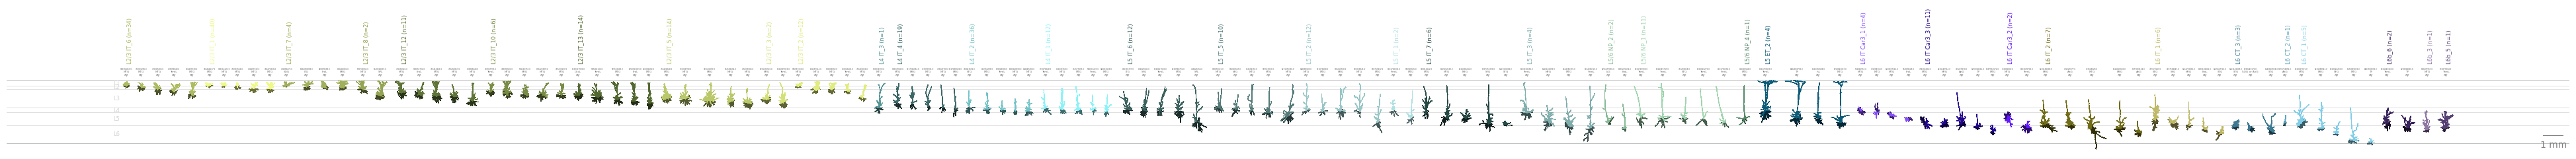

<Figure size 640x480 with 0 Axes>

In [7]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 900 #starting height for group (e.g., region) title 
group_title_font_size = 6 #font size for group (e.g., region) title 

cell_title_start_height = 700 #starting height for cell title 
cell_title_vertical_space = 150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)


    sps_list = list(sorted_cells_sampled.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=400
    with PdfPages(viewer_outfile) as pdf:
        #one fig per page, each has page (fig) has 8 rows. 
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(50, 5),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},

        ax.axis('off')
        xoffset = 0
        ax.set_anchor('W')
        ax.axhline(0, c="lightgrey",linewidth=0.50)

        for l in layer_info:
            ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
        for l in layer_labels:
            ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=group_title_font_size, color='lightgrey') 
            

            # while xloc < lim: #plot as many neurons as fit on this plot (layer row)
        while sps_list != []:
            if sps_list != []:
                sp = sps_list.pop() #the specimen to plot
                
                # get data for this specimen
                ttype = sorted_cells[sorted_cells.specimen_id==sp][ttype_var_name].iloc[0]
                clust_id = sorted_cells[sorted_cells.specimen_id==sp][cluster_var].iloc[0]
                clust_len = len(sorted_cells[sorted_cells[cluster_var]==clust_id])

                # title
                sp_title = []
                if 'title' in locals():
                    for t in title:
                        sp_title.append(str(sorted_cells[sorted_cells.specimen_id==sp][t].iloc[0]))
                
                try:
                    # decide the colors for this cells axon, apical, and basal
                    hex_color = color_dict[ttype][1:]

                    # hex_color = sorted_cells.color[sorted_cells.specimen_id == sp].iloc[0][1:]
                    contrast_level = 0.45
                    lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                    darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                    grey_hex = '#8f8f8f'
                    dark_hex = '#%02x%02x%02x' % darker_color_rgb
                    hex_color = '#'+hex_color

                    cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}
                    
                    if compartment_list == [1,2]: cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color} #for axon only plotting

                except: 
                    cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                
                morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                
                # get the layer-aligned file
                swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                nrn = morphology_from_swc(swc_pth)

                xoffset += leftextent(nrn,compartment_list)
                if clust_id not in clust_id_set:

                    y = cell_title_start_height #plot cell title 
                    i = 0
                    for l in sp_title:
                        y-=cell_title_vertical_space
                        ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                        i+=1

                    #plot cell cluster info (e.g. ttype and num cells)
                    ax.text(xoffset,group_title_start_height,
                    "{} (n={}) ".format(clust_id,clust_len),
                    horizontalalignment='left',fontsize=group_title_font_size, color=hex_color, rotation=90) 

                    str(sorted_cells[sorted_cells.specimen_id==sp][t].iloc[0])

                    clust_id_set.add(clust_id)

                    y-=cell_title_vertical_space
                    for s in set_side:
                        if s: v = 'yz'
                        else: v = 'xy'
                        ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                        basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s,
                                                     scatter_roots = False, scatter_soma = False, plot_soma = True)
                        xoffset += rightextent(nrn,compartment_list)
                        xoffset += buffer       

                else:
                        
                    clust_id_set.add(clust_id)
                    y = cell_title_start_height #plot cell title 
                    i = 0
                    for l in sp_title:
                        y-=cell_title_vertical_space
                        ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                        i+=1

                    y-=cell_title_vertical_space
                    for s in set_side:
                        if s: v = 'yz'
                        else: v = 'xy'
                        ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                        basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s,
                                                     scatter_roots = False, scatter_soma = False, plot_soma = True)
                        xoffset += rightextent(nrn,compartment_list)
                        xoffset += buffer

        #add scale bar at the end 
        scalebar = ScaleBar(1, "um", location='lower right', frameon=False, length_fraction=0.01, color='grey')
        ax.add_artist(scalebar)

        ax.set_aspect("equal")
        fig.subplots_adjust(wspace=0, hspace=0.0)
        pdf.savefig(dpi=600)
    plt.show()
    plt.clf()
    print()


A sea-ad L2/3 supertype viewer with 7 per type (where possible) that randomly samples the cortical depth all in one row. And if less than 7 cells just show all. 

In [8]:
viewer_outfile = os.path.join(viewer_dir, 'human_excitatory_single_row_L2-3_IT_viewer_{}_byTtypeHANN_bySomaDepth_sample7.pdf'.format(viewer_type))
viewer_outfile_saveIds = os.path.join(viewer_dir, 'human_excitatory_single_row_L2-3_IT_viewer_{}_byTtypeHANN_bySomaDepth_sample7.csv'.format(viewer_type)) #save ids in the viewer so we can reproduce this

sorted_cells_ttype = sorted_cells[sorted_cells[subclass_var_name] == 'L2/3 IT']

#get 7 random cells per L2/3 ttype (or all if <= 7 cells)
def sample_up_to_n(group, n=7):
    return group.sample(n=min(len(group), n), random_state=1)
sorted_cells_sampled = sorted_cells_ttype.groupby(ttype_var_name).apply(sample_up_to_n).reset_index(drop=True)

#save csv so we can reproduce this random sampled viewer
sorted_cells_sampled.to_csv(viewer_outfile_saveIds)
sorted_cells_sampled = sorted_cells_sampled.sort_values(by=sort_by)

title = ['specimen_id', 'structure'] #variables to put in cell title - must be column names in input cells csv
title_font_size = [2,3] #font size for parts of title


Sps list is 56 long


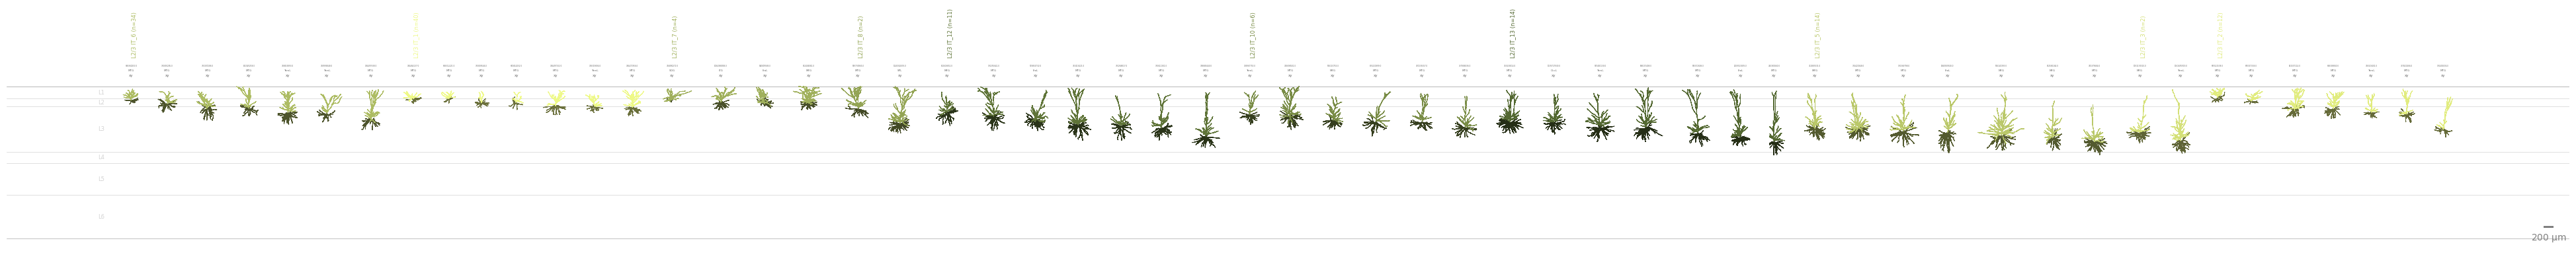

<Figure size 640x480 with 0 Axes>

In [9]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 600 #starting height for group (e.g., region) title 
group_title_font_size = 6 #font size for group (e.g., region) title 

cell_title_start_height = 500 #starting height for cell title 
cell_title_vertical_space = 100 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)


    sps_list = list(sorted_cells_sampled.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=400
    with PdfPages(viewer_outfile) as pdf:
        #one fig per page, each has page (fig) has 8 rows. 
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(50, 5),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},

        ax.axis('off')
        xoffset = 0
        ax.set_anchor('W')
        ax.axhline(0, c="lightgrey",linewidth=0.50)
        
        for l in layer_info:
            ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
        for l in layer_labels:
            ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=group_title_font_size, color='lightgrey') 
            

            # while xloc < lim: #plot as many neurons as fit on this plot (layer row)
        while sps_list != []:
            if sps_list != []:
                sp = sps_list.pop() #the specimen to plot
                
                # get data for this specimen
                ttype = sorted_cells[sorted_cells.specimen_id==sp][ttype_var_name].iloc[0]
                clust_id = sorted_cells[sorted_cells.specimen_id==sp][cluster_var].iloc[0]
                clust_len = len(sorted_cells[sorted_cells[cluster_var]==clust_id])

                # title
                sp_title = []
                if 'title' in locals():
                    for t in title:
                        sp_title.append(str(sorted_cells[sorted_cells.specimen_id==sp][t].iloc[0]))
                
                try:
                    # decide the colors for this cells axon, apical, and basal
                    hex_color = color_dict[ttype][1:]

                    # hex_color = sorted_cells.color[sorted_cells.specimen_id == sp].iloc[0][1:]
                    contrast_level = 0.45
                    lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                    darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                    grey_hex = '#8f8f8f'
                    dark_hex = '#%02x%02x%02x' % darker_color_rgb
                    hex_color = '#'+hex_color

                    cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}
                    
                    if compartment_list == [1,2]: cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color} #for axon only plotting

                except: 
                    cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                
                morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                
                # get the layer-aligned file
                swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                nrn = morphology_from_swc(swc_pth)

                xoffset += leftextent(nrn,compartment_list)
                if clust_id not in clust_id_set:

                    y = cell_title_start_height #plot cell title 
                    i = 0
                    for l in sp_title:
                        y-=cell_title_vertical_space
                        ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                        i+=1

                    #plot cell cluster info (e.g. ttype and num cells)
                    ax.text(xoffset,group_title_start_height,
                    "{} (n={}) ".format(clust_id,clust_len),
                    horizontalalignment='left',fontsize=group_title_font_size, color=hex_color, rotation=90) 

                    str(sorted_cells[sorted_cells.specimen_id==sp][t].iloc[0])

                    clust_id_set.add(clust_id)

                    y-=cell_title_vertical_space
                    for s in set_side:
                        if s: v = 'yz'
                        else: v = 'xy'
                        ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                        basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s,
                                                     scatter_roots = False, scatter_soma = False, plot_soma = True)
                        xoffset += rightextent(nrn,compartment_list)
                        xoffset += buffer       

                else:
                        
                    clust_id_set.add(clust_id)
                    y = cell_title_start_height #plot cell title 
                    i = 0
                    for l in sp_title:
                        y-=cell_title_vertical_space
                        ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                        i+=1

                    y-=cell_title_vertical_space
                    for s in set_side:
                        if s: v = 'yz'
                        else: v = 'xy'
                        ax.text(xoffset,y,v,horizontalalignment='center',fontsize=cell_title_view_font_size, color="dimgrey")

                        basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s,
                                                     scatter_roots = False, scatter_soma = False, plot_soma = True)
                        xoffset += rightextent(nrn,compartment_list)
                        xoffset += buffer

        #add scale bar at the end 
        scalebar = ScaleBar(1, "um", location='lower right', frameon=False, fixed_value=200, color='grey')
        ax.add_artist(scalebar)

        ax.set_aspect("equal")
        fig.subplots_adjust(wspace=0, hspace=0.0)
        pdf.savefig(dpi=600)
    plt.show()
    plt.clf()
    print()


SEAAD gallary. Cells in order given by RD. 20240912

In [10]:
#Cells from RD 

cells_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250701\human_excitatory_gallery_viewer_dendrite.csv')
cells_df[cluster_col] = pd.Categorical(cells_df[cluster_col], categories=ttype_order, ordered=True)
cells_df_sorted = cells_df.sort_values(cluster_col)
cells_df_sorted[[cluster_col, 'specimen_id']]


,cluster_label_assignment_winner,specimen_id
0,L2/3 IT_6,785378321
1,L2/3 IT_1,539736968
2,L2/3 IT_7,1084380898
3,L2/3 IT_8,539736965
4,L2/3 IT_12,767415421
5,L2/3 IT_10,737988336
6,L2/3 IT_13,793615764
7,L2/3 IT_5,767422070
8,L2/3 IT_3,1161695919
9,L2/3 IT_2,987474935


In [11]:
# #update the gallery cells 20250710
# use_these = {
#     'L2/3 IT_1' : 539736968,
#     'L2/3 IT_10' : 737988336,
#     'L2/3 IT_2' : 987474935,
#     'L5 IT_7' : 1325022560,
#     'L5 ET_2' : 1402898753,
#     'L6 CT_1' : 1272049036
# }

# #load metadata for al cells
# metadata_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250701\Datalock_Human_Glut_4_4_25(patchseq_mapping_results).csv', encoding='latin1')
# metadata_df = metadata_df.rename(columns={'cell_id': 'specimen_id'})
# metadata_df = metadata_df[~metadata_df.specimen_id.isna()]
# metadata_df['specimen_id'] = metadata_df['specimen_id'].astype(int)

# #load old gallery cells
# cells_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250414\human_excitatory_gallery_viewer_dendrite.csv')
# cells_df = cells_df[cells_df['to use?'] == 'use me']
# cells_df[cluster_col] = pd.Categorical(cells_df[cluster_col], categories=order, ordered=True)
# cells_df_sorted = cells_df.sort_values(cluster_col)
# cells_df_sorted = cells_df_sorted[[cluster_col, 'specimen_id']]
# cells_df_sorted = cells_df_sorted.set_index(cluster_col)

# #exchange new gallery cells
# for key, val in use_these.items():
#     cells_df_sorted.at[key, 'specimen_id'] = val
# cells_df_sorted = cells_df_sorted.reset_index()

# #merge with metadta
# overlap = cells_df_sorted.columns.intersection(metadata_df.columns).difference(['specimen_id']) # Drop overlapping columns from right, except merge keys
# metadata_df = metadata_df.drop(columns=overlap)
# cells_df_sorted = cells_df_sorted.merge(metadata_df, how='left', on='specimen_id')

# #save
# cells_df_sorted.to_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250701\human_excitatory_gallery_viewer_dendrite.csv', index=False)


In [17]:
out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250721_seaad\viewers'
os.makedirs(out_dir, exist_ok=True)
viewer_outfile = os.path.join(out_dir, 'human_excitatory_gallery_viewer_{}.pdf'.format(viewer_type))
viewer_outfile_saveIds = os.path.join(out_dir, 'human_excitatory_gallery_viewer_{}.csv'.format(viewer_type)) #save ids in the viewer so we can reproduce this

cells_df_sorted[[cluster_col, 'specimen_id']].to_csv(viewer_outfile_saveIds, index=False)

Sps list is 36 long


C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21168\1485889544.py:107: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  fig.subplots_adjust(wspace=0, hspace=0.0)


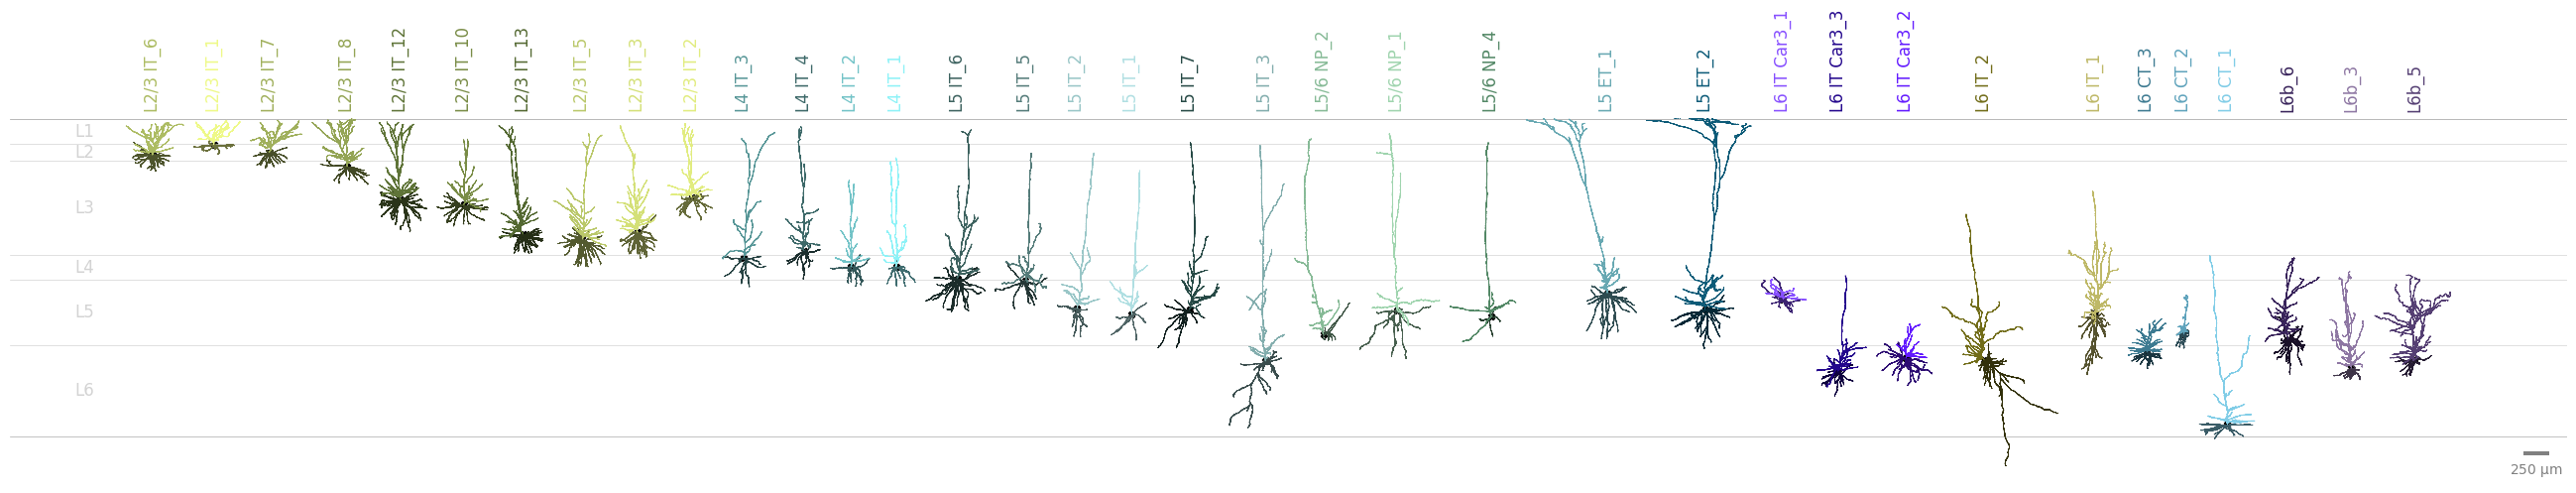

<Figure size 640x480 with 0 Axes>

In [26]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 100 #starting height for group (e.g., region) title 
group_title_font_size = 12 #font size for group (e.g., region) title 

cell_title_start_height = 700 #starting height for cell title 
cell_title_vertical_space = 150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)


    sps_list = list(cells_df_sorted.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=100
    with PdfPages(viewer_outfile) as pdf:
        #one fig per page, each has page (fig) has 8 rows. 
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(50, 5),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},

        ax.axis('off')
        xoffset = 0
        ax.set_anchor('W')
        ax.axhline(0, c="lightgrey",linewidth=0.50)
        
        layer_colors = {'2': 'lightgrey', '3': 'lightgrey', '4': 'lightgrey','5': 'lightgrey','6': 'lightgrey','wm': 'darkgrey','1': 'darkgrey'}
        layer_labels = {'L1': 123.96693702975,'L2': 329.00571107235,'L3': 866.1912134781501,'L4': 1440.0541559901499,'L5': 1873.5905035123499,'L6': 2633.371930518}
        
        for l in layer_info:
            ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
        for l in layer_labels:
            ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=group_title_font_size, color='lightgrey') 
            
        while sps_list != []:
            if sps_list != []:
                sp = sps_list.pop() #the specimen to plot
                
                # get data for this specimen
                ttype = cells_df_sorted[cells_df_sorted.specimen_id==sp][ttype_var_name].iloc[0]
                clust_id = cells_df_sorted[cells_df_sorted.specimen_id==sp][cluster_var].iloc[0]
                # clust_len = len(cells_df_sorted[cells_df_sorted[cluster_var]==clust_id])

                try:
                    # decide the colors for this cells axon, apical, and basal
                    hex_color = color_dict[ttype][1:]
                    contrast_level = 0.45
                    lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                    darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                    grey_hex = '#8f8f8f'
                    dark_hex = '#%02x%02x%02x' % darker_color_rgb
                    hex_color = '#'+hex_color

                    cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}
                    
                    if compartment_list == [1,2]: cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color} #for axon only plotting

                except: 
                    print(sp)
                    print(ttype)
                    cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                
                morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                
                # get the layer-aligned file
                swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                nrn = morphology_from_swc(swc_pth)

                xoffset += leftextent(nrn,compartment_list)
                if clust_id not in clust_id_set:

                    #plot cell cluster info (e.g. ttype and num cells)
                    ax.text(xoffset,group_title_start_height,
                    "{}".format(clust_id),
                    horizontalalignment='center',fontsize=group_title_font_size, color=hex_color, rotation=90) 

                    clust_id_set.add(clust_id)

                    for s in set_side:
                        basic_morph_plot(nrn,morph_colors=morph_colors, 
                                    ax=ax, xoffset=xoffset,side=s)
                        xoffset += rightextent(nrn,compartment_list)
                        xoffset += buffer       

                else:
                        
                    clust_id_set.add(clust_id)

                    for s in set_side:
                        basic_morph_plot(nrn,morph_colors=morph_colors, 
                                    ax=ax, xoffset=xoffset,side=s)
                        xoffset += rightextent(nrn,compartment_list)
                        xoffset += buffer

        #add scale bar at the end 
        scalebar = ScaleBar(1, "um", location='lower right', frameon=False, fixed_value=250,  color='grey')
        ax.add_artist(scalebar)

        ax.set_aspect("equal")
        fig.subplots_adjust(wspace=0, hspace=0.0)
        # pdf.savefig(dpi=600, bbox_inches='tight')
    plt.show()
    plt.clf()
    print()


Gallery (same as above) with soma depths

In [20]:
viewer_outfile = os.path.join(out_dir, 'human_excitatory_gallery_viewer_{}_somaDepths.pdf'.format(viewer_type))


Sps list is 36 long


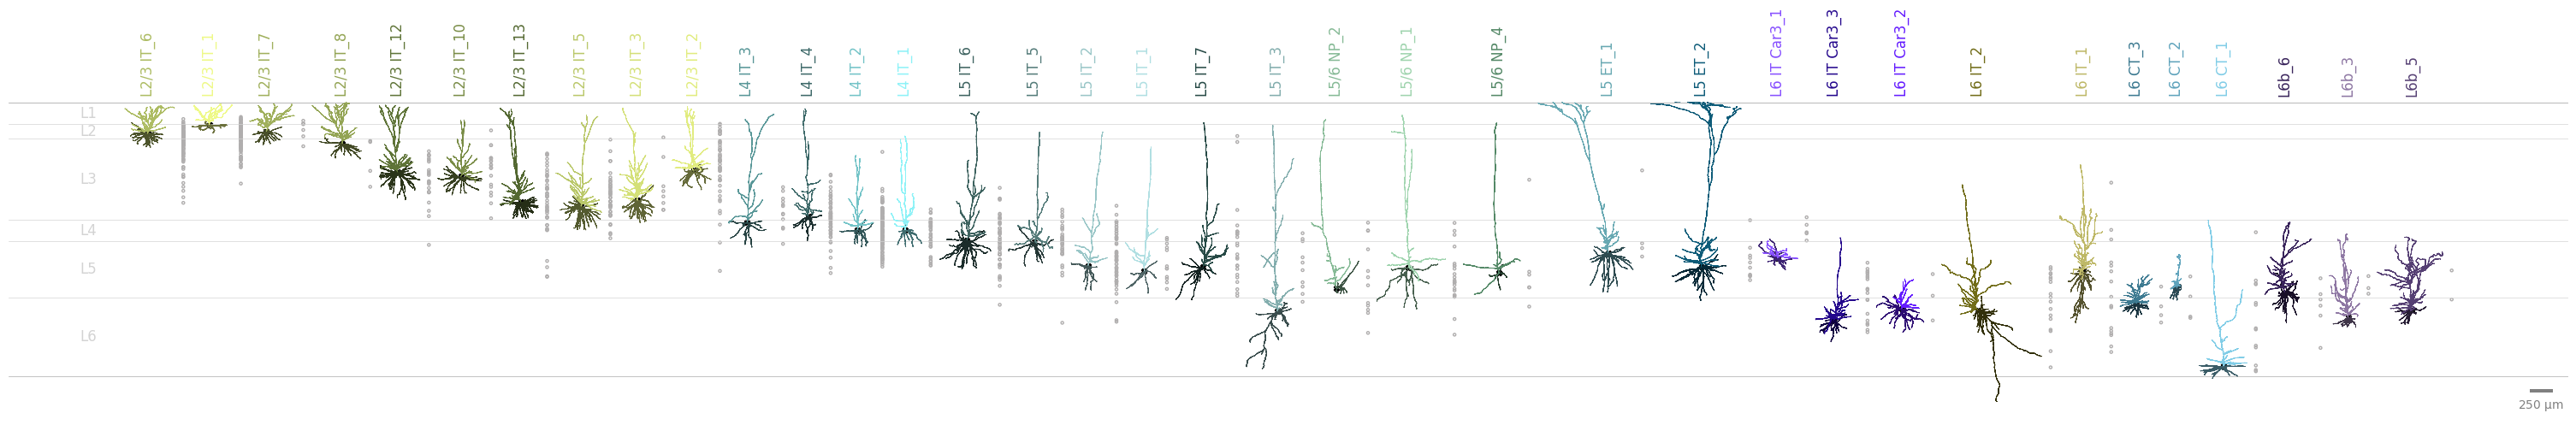

<Figure size 640x480 with 0 Axes>

In [27]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 100 #starting height for group (e.g., region) title 
group_title_font_size = 12 #font size for group (e.g., region) title 

cell_title_start_height = 700 #starting height for cell title 
cell_title_vertical_space = 150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)


    sps_list = list(cells_df_sorted.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=100
    with PdfPages(viewer_outfile) as pdf:
        #one fig per page, each has page (fig) has 8 rows. 
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(50, 5),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},

        ax.axis('off')
        xoffset = 0
        ax.set_anchor('W')
        ax.axhline(0, c="lightgrey",linewidth=0.50)
        
        layer_colors = {'2': 'lightgrey', '3': 'lightgrey', '4': 'lightgrey','5': 'lightgrey','6': 'lightgrey','wm': 'darkgrey','1': 'darkgrey'}
        layer_labels = {'L1': 123.96693702975,'L2': 329.00571107235,'L3': 866.1912134781501,'L4': 1440.0541559901499,'L5': 1873.5905035123499,'L6': 2633.371930518}
        
        for l in layer_info:
            ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
        for l in layer_labels:
            ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=group_title_font_size, color='lightgrey') 
            
        while sps_list != []:
            if sps_list != []:
                sp = sps_list.pop() #the specimen to plot
                
                # get data for this specimen
                ttype = cells_df_sorted[cells_df_sorted.specimen_id==sp][ttype_var_name].iloc[0]
                clust_id = cells_df_sorted[cells_df_sorted.specimen_id==sp][cluster_var].iloc[0]
                # clust_len = len(cells_df_sorted[cells_df_sorted[cluster_var]==clust_id])

                try:
                    # decide the colors for this cells axon, apical, and basal
                    hex_color = color_dict[ttype][1:]
                    contrast_level = 0.45
                    lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                    darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                    grey_hex = '#8f8f8f'
                    dark_hex = '#%02x%02x%02x' % darker_color_rgb
                    hex_color = '#'+hex_color

                    cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}
                    
                    if compartment_list == [1,2]: cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color} #for axon only plotting

                except: 
                    cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                
                morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                
                # get the layer-aligned file
                swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                nrn = morphology_from_swc(swc_pth)

                xoffset += leftextent(nrn,compartment_list)
                if clust_id not in clust_id_set:

                    #plot cell cluster info (e.g. ttype and num cells)
                    ax.text(xoffset,group_title_start_height,
                    "{}".format(clust_id),
                    horizontalalignment='center',fontsize=group_title_font_size, color=hex_color, rotation=90) 

                    clust_id_set.add(clust_id)

                    basic_morph_plot(nrn,morph_colors=morph_colors, 
                                ax=ax, xoffset=xoffset)
                    xoffset += rightextent(nrn,compartment_list)

                    xoffset += buffer       

                    #plot all the soma depths for this clust_id
                    soma_depths = [-1 * d for d in metadata[metadata[cluster_var] == clust_id]['depth_from_pia_norm_to_layers'].tolist()]
                    if len(soma_depths) > 0:
                        ax.scatter([xoffset] * len(soma_depths), soma_depths, facecolors='none', edgecolors='#b0aeae', marker='o', s=5)
                    
                    xoffset += buffer       

                else:
                        
                    clust_id_set.add(clust_id)

                    basic_morph_plot(nrn,morph_colors=morph_colors, 
                                ax=ax, xoffset=xoffset)
                    xoffset += rightextent(nrn,compartment_list)
                    xoffset += buffer
                
        #add scale bar at the end 
        scalebar = ScaleBar(1, "um", location='lower right', frameon=False, fixed_value=250,  color='grey')
        ax.add_artist(scalebar)

        ax.set_aspect("equal")
        fig.subplots_adjust(wspace=0, hspace=0.0)
        pdf.savefig(dpi=600, bbox_inches='tight')
    plt.show()
    plt.clf()
    print()


Gallery with Ephys

In [29]:
import matplotlib.pyplot as plt
from svgpathtools import svg2paths
from matplotlib.path import Path
import matplotlib.patches as patches

In [28]:
out_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250603_seaad\viewers'
viewer_ids = pd.read_csv(os.path.join(out_dir, 'human_excitatory_gallery_viewer_{}.csv'.format(viewer_type))) 
supertype_order = viewer_ids['cluster_label_assignment_winner'].tolist()
supertype_order = [s.replace('/', '').replace(' ', '_') for s in supertype_order]


In [30]:
svg_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250716\ephys_trace_svgs'

In [ ]:
# def svg_path_to_mpl_path(svg_path):
#     verts = []
#     codes = []
#     for i, segment in enumerate(svg_path):
#         start = segment.start
#         end = segment.end

#         if i == 0:
#             verts.append((start.real, start.imag))
#             codes.append(Path.MOVETO)
#         verts.append((end.real, end.imag))
#         codes.append(Path.LINETO)
#     return Path(verts, codes)

# def translate_path(mpl_path, dx, dy):
#     verts = mpl_path.vertices.copy()
#     verts[:, 0] += dx
#     verts[:, 1] += dy
#     return Path(verts, mpl_path.codes)

# def get_svg_bounding_box(paths):
#     all_x = []
#     all_y = []
#     for path in paths:
#         for segment in path:
#             all_x.extend([segment.start.real, segment.end.real])
#             all_y.extend([segment.start.imag, segment.end.imag])
#     return min(all_x), max(all_x), min(all_y), max(all_y)

# def plot_svgs_along_x(ax, svg_filenames, svg_dir, xoffset, yoffset=0, trace_type='', color_dict=color_dict):
#     current_x = 0

#     for svg_file in svg_filenames:
#         full_path = os.path.join(svg_dir, f"{svg_file}{trace_type}.svg")
#         if os.path.exists(full_path):
#             paths, _ = svg2paths(full_path)

#             xmin, xmax, ymin, ymax = get_svg_bounding_box(paths)
#             width = xmax - xmin
#             # height = ymax - ymin
#             # y_shift = yoffset - ymin

#             # Plot each path, translating by current_x - xmin to align left edges at current_x
#             for path in paths:
#                 mpl_path = svg_path_to_mpl_path(path)
#                 # shift so left edge of SVG aligns at current_x
#                 shifted_path = translate_path(mpl_path, current_x - xmin, yoffset)
#                 patch = patches.PathPatch(shifted_path, facecolor='none', 
#                                           edgecolor=color_dict[svg_file.replace('23', '2/3').replace('56', '5/6').replace('_IT', ' IT').replace('_NP', ' NP').replace('_ET', ' ET').replace('_CT', ' CT').replace('_Car3', ' Car3')]) #'black')
#                 ax.add_patch(patch)

#             current_x += width + xoffset
#         else: 
#             print(f'File not found: {full_path}')


#     ax.set_aspect('equal')
#     ax.autoscale()
#     # plt.show()


File not found: \\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250716\ephys_trace_svgs\L6b_5_rate.svg
File not found: \\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250716\ephys_trace_svgs\L6b_5_width.svg


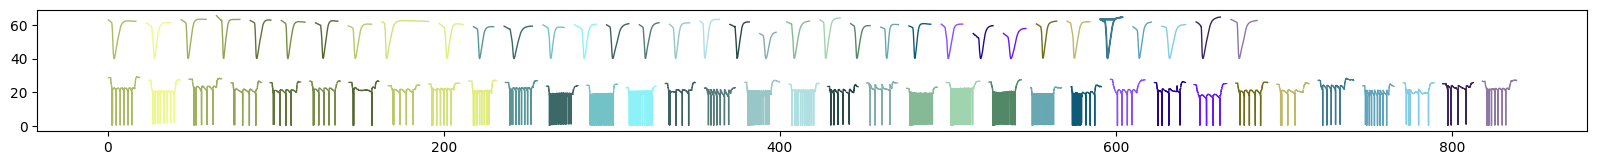

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

spacing = 5  # space between SVGs along x axis
plot_svgs_along_x(ax, supertype_order, svg_root, 5, trace_type='_rate', yoffset=0)
plot_svgs_along_x(ax, supertype_order, svg_root, 5.5, trace_type='_width', yoffset=40)



In [39]:
from matplotlib.path import Path
from matplotlib import patches
from svgpathtools import svg2paths
import os

def svg_path_to_mpl_path(svg_path):
    verts = []
    codes = []
    for i, segment in enumerate(svg_path):
        start = segment.start
        end = segment.end
        if i == 0:
            verts.append((start.real, start.imag))
            codes.append(Path.MOVETO)
        verts.append((end.real, end.imag))
        codes.append(Path.LINETO)
    return Path(verts, codes)

def translate_path(mpl_path, dx, dy):
    verts = mpl_path.vertices.copy()
    verts[:, 0] += dx
    verts[:, 1] += dy
    return Path(verts, mpl_path.codes)

def get_svg_bounding_box(paths):
    all_x = []
    all_y = []
    for path in paths:
        for segment in path:
            all_x.extend([segment.start.real, segment.end.real])
            all_y.extend([segment.start.imag, segment.end.imag])
    return min(all_x), max(all_x), min(all_y), max(all_y)

def plot_svg_on_ax(ax, svg_path, xoffset=0, yoffset=0, color='black'):
    if not os.path.exists(svg_path):
        print(f"File not found: {svg_path}")
        return

    paths, _ = svg2paths(svg_path)
    xmin, xmax, ymin, ymax = get_svg_bounding_box(paths)

    for path in paths:
        mpl_path = svg_path_to_mpl_path(path)
        shifted_path = translate_path(mpl_path, xoffset - xmin, yoffset - ymin)
        patch = patches.PathPatch(shifted_path, facecolor='none', edgecolor=color)
        ax.add_patch(patch)

    ax.set_aspect('equal')
    ax.autoscale()


Sps list is 36 long
File not found: \\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250716\ephys_trace_svgs\L6b_5_width.svg
File not found: \\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\ephys\20250716\ephys_trace_svgs\L6b_5_rate.svg


C:\Users\sarah.wallingbell\AppData\Local\Temp\ipykernel_21168\2176571306.py:101: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  fig.subplots_adjust(wspace=0, hspace=0.0)


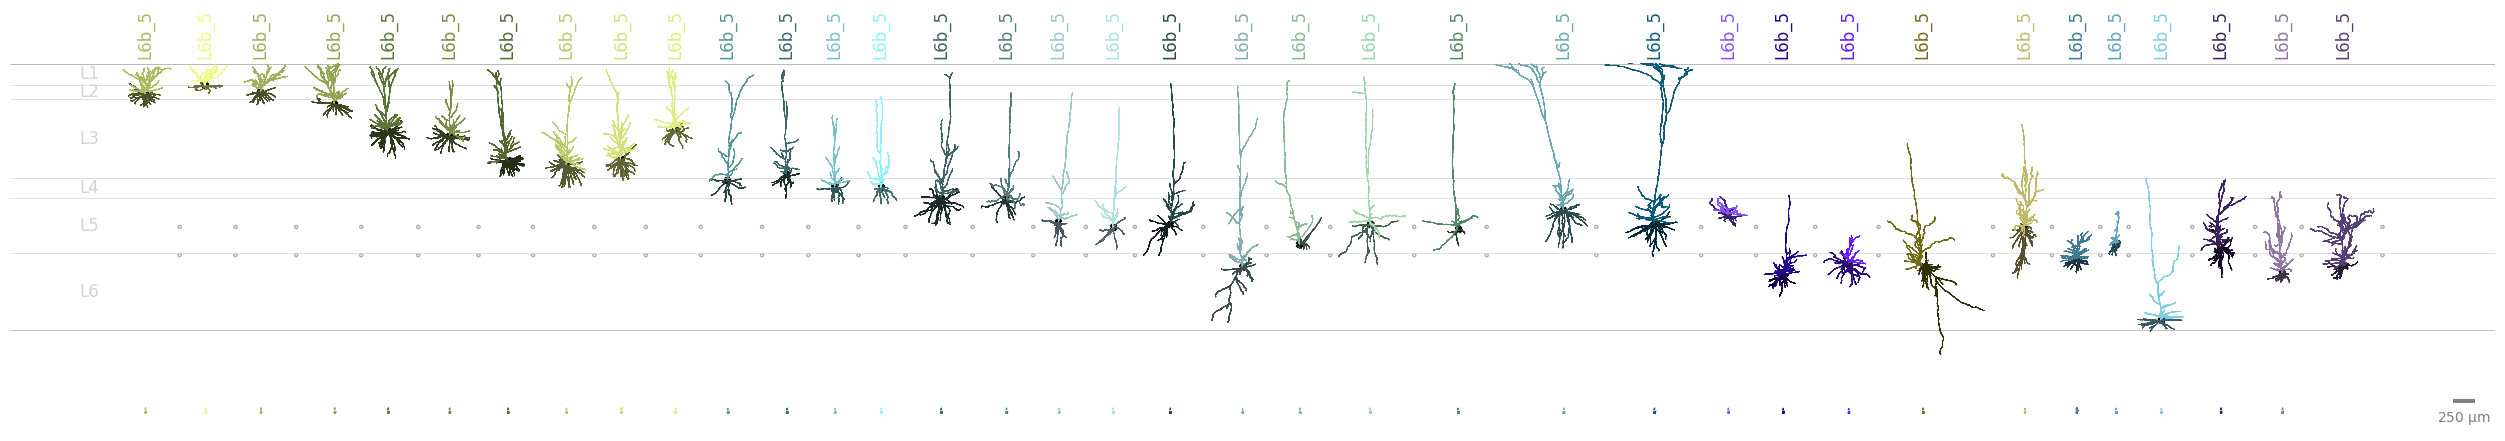

<Figure size 640x480 with 0 Axes>

In [40]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 100 #starting height for group (e.g., region) title 
group_title_font_size = 12 #font size for group (e.g., region) title 

cell_title_start_height = 700 #starting height for cell title 
cell_title_vertical_space = 150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    sps_list = list(cells_df_sorted.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    # clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=100
    with PdfPages(viewer_outfile) as pdf:
        #one fig per page, each has page (fig) has 8 rows. 
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(50, 5),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) #gridspec_kw = {'wspace':0, 'hspace':0},

        ax.axis('off')
        xoffset = 0
        ax.set_anchor('W')
        ax.axhline(0, c="lightgrey",linewidth=0.50)
        
        layer_colors = {'2': 'lightgrey', '3': 'lightgrey', '4': 'lightgrey','5': 'lightgrey','6': 'lightgrey','wm': 'darkgrey','1': 'darkgrey'}
        layer_labels = {'L1': 123.96693702975,'L2': 329.00571107235,'L3': 866.1912134781501,'L4': 1440.0541559901499,'L5': 1873.5905035123499,'L6': 2633.371930518}
        
        for l in layer_info:
            ax.axhline(-layer_info[l], c=layer_colors[l],linewidth=0.50)
        for l in layer_labels:
            ax.text(-500,-layer_labels[l], "{}".format(l),verticalalignment='center', horizontalalignment='left',fontsize=group_title_font_size, color='lightgrey') 
            
        while sps_list != []:
            if sps_list != []:
                sp = sps_list.pop() #the specimen to plot
                
                # get data for this specimen
                ttype = cells_df_sorted[cells_df_sorted.specimen_id==sp][ttype_var_name].iloc[0]
                # clust_id = cells_df_sorted[cells_df_sorted.specimen_id==sp][cluster_var].iloc[0]
                # clust_len = len(cells_df_sorted[cells_df_sorted[cluster_var]==clust_id])

                try:
                    # decide the colors for this cells axon, apical, and basal
                    hex_color = color_dict[ttype][1:]
                    contrast_level = 0.45
                    lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                    darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                    grey_hex = '#8f8f8f'
                    dark_hex = '#%02x%02x%02x' % darker_color_rgb
                    hex_color = '#'+hex_color

                    cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}
                    
                    if compartment_list == [1,2]: cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color} #for axon only plotting

                except: 
                    cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                
                morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                
                # get the layer-aligned file
                swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                nrn = morphology_from_swc(swc_pth)
                xoffset += leftextent(nrn,compartment_list)

                #plot cell cluster info (e.g. ttype and num cells)
                ax.text(xoffset,group_title_start_height,
                "{}".format(clust_id),
                horizontalalignment='center',fontsize=group_title_font_size, color=hex_color, rotation=90) 

                #plot morphology
                basic_morph_plot(nrn,morph_colors=morph_colors, ax=ax, xoffset=xoffset)
                svg_file_root = ttype.replace('/', '').replace(' ', '_')
                plot_svg_on_ax(ax, svg_path=os.path.join(svg_root, f'{svg_file_root}_width.svg'), xoffset=xoffset, yoffset=-4000, color=hex_color)
                plot_svg_on_ax(ax, svg_path=os.path.join(svg_root, f'{svg_file_root}_rate.svg'), xoffset=xoffset, yoffset=-4040, color=hex_color)

                #move to next supertype loc
                xoffset += rightextent(nrn,compartment_list)
                xoffset += buffer       

                #plot all the soma depths for this clust_id
                soma_depths = [-1 * d for d in metadata[metadata[cluster_var] == clust_id]['depth_from_pia_norm_to_layers'].tolist()]
                if len(soma_depths) > 0:
                    ax.scatter([xoffset] * len(soma_depths), soma_depths, facecolors='none', edgecolors='#b0aeae', marker='o', s=5)
                
                xoffset += buffer       
    
        #add scale bar at the end 
        scalebar = ScaleBar(1, "um", location='lower right', frameon=False, fixed_value=250,  color='grey')
        ax.add_artist(scalebar)

        ax.set_aspect("equal")
        fig.subplots_adjust(wspace=0, hspace=0.0)
        # pdf.savefig(dpi=600, bbox_inches='tight')
    plt.show()
    plt.clf()
    print()
